## Implementation
### Import libraries & dataset
First I would like to import some libraries needed and the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('winequality-red.csv')
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

### Checking missing values in variables
We want to make sure that we will not deal with NULL values. In case there are NULL values, we can perform some techniques such as eliminating the row containing NULL values if the number of NULL values is small.

In [2]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Luckily, our dataset does not have any missing values in each variable.

### Preprocessing data

In [3]:
# quality is the target variable
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

### Target variable visualization

<AxesSubplot:>

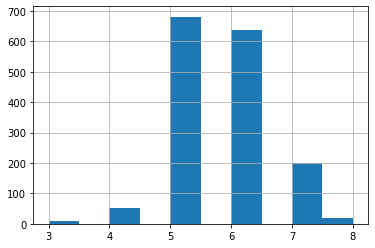

In [4]:
df.quality.hist()

From the histogram above, we can conclude that the distribution of the red wine quality is symmetric. Most of the red wine has the quality from 5 to 6. There is a few red wine can reach the quality 7 or above.

In [5]:
import plotly.graph_objects as go

fig = go.Figure(data = [go.Pie(labels = df.quality.value_counts().index, values = df.quality.value_counts())])
fig.show()

You can see that Quality column's data is not properly distributed so I convert it into 0 and 1 <br>
[3, 4, 5] = 0: Low quality wine <br>
[6, 7, 8] = 1: High quality wine

In [6]:
df.quality = df.quality.replace([3,4,5],0)
df.quality = df.quality.replace([6,7,8],1)
df.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

In [7]:
labels = ['High quality','Low quality']
fig = go.Figure(data = [go.Pie(labels = labels, values = df.quality.value_counts())])
fig.show()

### Declare feature vector and target variable
In here, y contains only the target variable, which is class. X contains other variables

In [8]:
X = df.drop(['quality'], axis=1)
y = df['quality']

### Splitting data into separate training and test set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Decision Tree Classifier model with criterion Gini Index

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf_gini = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state = 0)

clf_gini.fit(X_train, y_train)
y_pred_gini = clf_gini.predict(X_test)

print('Model accuracy score with criterion gini index: {0:0.4f}'.format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.7027


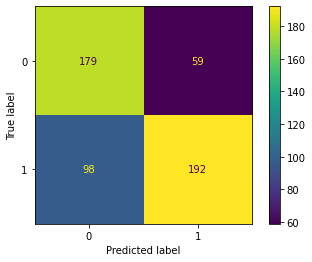

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf_gini, X_test, y_test)  
# plt.show()
plt.savefig('confusion_matrix_dt.pdf')

Now, I will perform the Random Forest Classifier model with default parameters, which is n_estimators = 100, to see its effect on accuracy.

### Random Forest Classifier model with default parameters

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc_100 = RandomForestClassifier(n_estimators = 100, random_state = 0)
rfc_100.fit(X_train, y_train)
y_pred_100 = rfc_100.predict(X_test)

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.7841


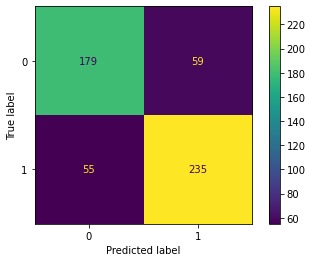

In [13]:
plot_confusion_matrix(rfc_100, X_test, y_test)  
# plt.show()
plt.savefig('confusion_matrix_rfc_100.pdf')

### Random Forest Classifier model with important features
Until now, I have used all the features given in the model. Now I will select only the important features to build the model and see its effect on accuracy. <br>
At first, I will create the classifier and use the feature importance variable to see feature importance scores.

In [14]:
# create the classifier with n_estimators = 100
clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf.fit(X_train, y_train)

# view the feature scores
feature_scores = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feature_scores

alcohol                 0.195851
sulphates               0.138668
total sulfur dioxide    0.101943
volatile acidity        0.101689
density                 0.090099
chlorides               0.072706
fixed acidity           0.064221
citric acid             0.062682
residual sugar          0.058811
pH                      0.058556
free sulfur dioxide     0.054775
dtype: float64

From the table above, we can conclude that alcohol is the most important feature whereas "free sulfur dioxide" is the least one.

### Visualize feature scores of the features
In this section, I visualize the feature scores with matplotlib and seaborn.

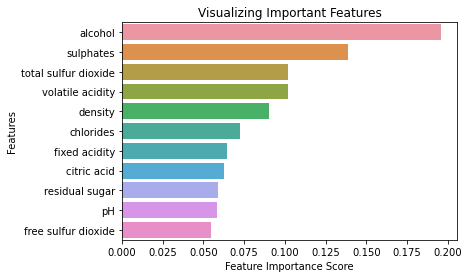

In [15]:
sns.barplot(x = feature_scores, y = feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

plt.title("Visualizing Important Features")
# plt.show()
plt.savefig('important_features.pdf')

### Random Forest model on selected features
Because "free sulfur dioxide" is the least important feature, I will drop it from the model and rebuild the model to see its effect on accuracy. <br>
We also perform splitting data into training and testing sets

In [16]:
X = df.drop(['quality', 'free sulfur dioxide'], axis = 1)
y = df['quality']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

After that, I build the Random Forest model and check the accuracy.

In [17]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Model accuracy score with "free sulfur dioxide" variable removed : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with "free sulfur dioxide" variable removed : 0.8030


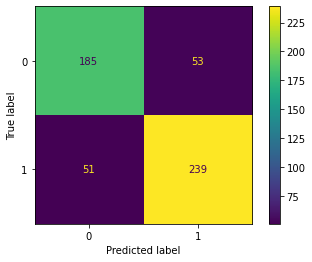

In [18]:
plot_confusion_matrix(clf, X_test, y_test)  
# plt.show()
plt.savefig('confusion_matrix_sf.pdf')

The accuracy of the model without "free sulfur dioxide" feature is 0.8030. <br>
The accuracy of the model with "free sulfur dioxide" feature is 0.7841. (Both model with n_estimators = 100). <br>
We can conclude that the model accuracy has been improved with "free sulfur dioxide" variable removed from the model.

### Conclusion
Based on the above analysis, we can say that our classification model accuracy is pretty good. It does great job in predicting the class labels.